In [37]:
import os
import sys
from datetime import datetime
from pathlib import Path
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
from pysankey import sankey

plt.rcParams['pdf.fonttype'] = 42

In [38]:
annotations_df = pd.read_excel('Table_SX_annotation_including_imaging.xlsx', sheet_name='annotations_with_imaging')
annotations_df.head()

,target_name,ensg_id,annotations_grade_3,annotations_grade_2,annotations_grade_1,graph_annotation,classifier_annotation,annotations_grade_3_wo_aggregates,annotations_grade3_simpler
0,GJA1,ENSG00000152661,cell_contact,NaN,vesicles,plasma_membrane,plasma_membrane,cell_contact,plasma_membrane
1,HOMER1,ENSG00000152413,cell_contact,centrosome,cytoplasmic;nucleoplasm,unclassified,centrosome,cell_contact,plasma_membrane
2,TJP1,ENSG00000104067,cell_contact,NaN,NaN,actin_cytoskeleton,actin_cytoskeleton,cell_contact,plasma_membrane
3,TJP2,ENSG00000119139,cell_contact,NaN,cytoplasmic,plasma_membrane,actin_cytoskeleton,cell_contact,plasma_membrane
4,ZYX,ENSG00000159840,cell_contact,NaN,NaN,actin_cytoskeleton,actin_cytoskeleton,cell_contact,plasma_membrane


In [39]:
annotations_df.shape[0]

1310

In [40]:
data = annotations_df[(annotations_df["graph_annotation"].notna()) & (annotations_df["graph_annotation"] != "unclassified") & (annotations_df["annotations_grade3_simpler"] != "mixed")]
data.shape[0]


931

In [41]:
data["annotations_grade3_simpler"].unique()

array(['plasma_membrane', 'centrosome', 'nucleus', 'cytoplasm',
       'cytoskeleton', 'ER', 'Golgi', 'mitochondria', 'nuclear_membrane',
       'nucleolus', 'vesicles'], dtype=object)

In [42]:
data["graph_annotation"].unique()

array(['plasma_membrane', 'actin_cytoskeleton', 'cytosol',
       'recycling_endosome', 'centrosome', 'nucleus', '14-3-3_scaffold',
       'nucleolus', 'translation', 'stress_granule', 'lysosome', 'ER',
       'early_endosome', 'proteasome', 'trans-Golgi', 'ERGIC', 'Golgi',
       'mitochondrion', 'p-body', 'peroxisome'], dtype=object)

<AxesSubplot:>

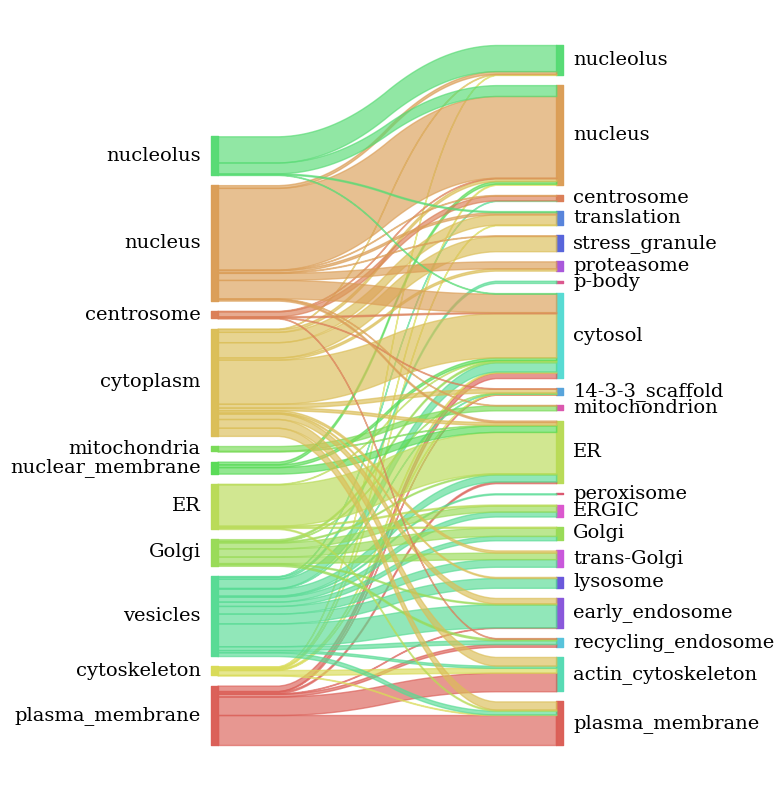

In [43]:
left_order= ['plasma_membrane', 'cytoskeleton', 'vesicles', 'Golgi', 
'ER', 'nuclear_membrane', 'mitochondria', 'cytoplasm', 'centrosome', 'nucleus', 'nucleolus']

right_order = ['plasma_membrane', 'actin_cytoskeleton', 'recycling_endosome', 'early_endosome', 
 'lysosome', 'trans-Golgi', 'Golgi', 'ERGIC', 'peroxisome',  'ER', 'mitochondrion', '14-3-3_scaffold', 
 'cytosol', 'p-body', 'proteasome', 'stress_granule', 'translation', 'centrosome', 'nucleus', 'nucleolus']

plt.figure(figsize=(5,10))

sankey(data["annotations_grade3_simpler"], data["graph_annotation"], leftLabels=left_order, rightLabels=right_order)
#sankey(data["annotations_grade3_simpler"], data["graph_annotation"])



In [44]:
data_single = annotations_df[(annotations_df["graph_annotation"].notna()) & (annotations_df["annotations_grade_2"].isna()) & (annotations_df["annotations_grade3_simpler"] != "mixed") & (annotations_df["graph_annotation"] != "unclassified")]
data_single.shape[0]

576

In [45]:
data_single["annotations_grade3_simpler"].unique()

array(['plasma_membrane', 'centrosome', 'nucleus', 'cytoplasm',
       'cytoskeleton', 'ER', 'Golgi', 'mitochondria', 'nuclear_membrane',
       'nucleolus', 'vesicles'], dtype=object)

In [46]:
data_single["graph_annotation"].unique()

array(['plasma_membrane', 'actin_cytoskeleton', 'cytosol',
       'recycling_endosome', 'centrosome', 'nucleus', 'nucleolus',
       'stress_granule', '14-3-3_scaffold', 'lysosome', 'translation',
       'ER', 'early_endosome', 'proteasome', 'trans-Golgi', 'ERGIC',
       'Golgi', 'mitochondrion', 'p-body', 'peroxisome'], dtype=object)

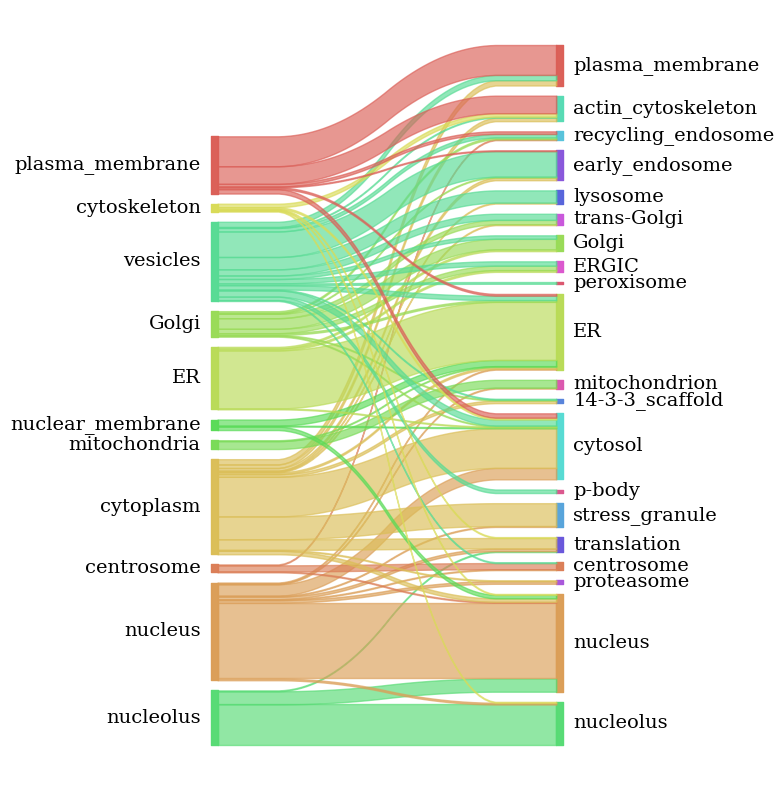

In [47]:
left_order= ['plasma_membrane', 'cytoskeleton', 'vesicles', 'Golgi', 
'ER', 'nuclear_membrane', 'mitochondria', 'cytoplasm', 'centrosome', 'nucleus', 'nucleolus']

right_order = ['plasma_membrane', 'actin_cytoskeleton', 'recycling_endosome', 'early_endosome', 
 'lysosome', 'trans-Golgi', 'Golgi', 'ERGIC', 'peroxisome',  'ER', 'mitochondrion', '14-3-3_scaffold', 
 'cytosol', 'p-body', 'stress_granule', 'translation', 'centrosome', 'proteasome', 'nucleus', 'nucleolus']

plt.figure(figsize=(5,10))

sankey(data_single["annotations_grade3_simpler"], data_single["graph_annotation"], leftLabels=left_order[::-1], rightLabels=right_order[::-1])
#sankey(data["annotations_grade3_simpler"], data["graph_annotation"])

plt.savefig("Sankey_imaging.pdf")


### confusion matrix

In [48]:
# enumerate all pairwise combinations of annotations between cytoself (left order) and OrgIP (right order)
import itertools
combinations = list(itertools.product(left_order, right_order))

In [49]:
# compute IoU
def compute_IoU(list1, list2, list1_item, list2_item):
    """
    Compute the intersection over union for two lists of annotations
    list1_item: the item in list1 to compare
    list2_item: the item in list2 to compare
    """
    assert list1_item in list1, f"{list1_item} not in {list1}"
    assert list2_item in list2, f"{list2_item} not in {list2}"

    intersection = sum((l1 == list1_item and l2 == list2_item) for l1, l2 in zip(list1, list2))
    union = sum((l1 == list1_item or l2 == list2_item) for l1, l2 in zip(list1, list2))
    if union == 0:
        return 0
    return round(intersection / union *100) # in percentage

confusion_results = {}

for combo in combinations:
    cytoself_label = combo[0]
    OrgIP_label = combo[1]
    IoU = compute_IoU(data_single["annotations_grade3_simpler"].to_list(), 
                      data_single["graph_annotation"].to_list(), 
                      cytoself_label, OrgIP_label)
    confusion_results[combo] = IoU


In [50]:
# process the results for plotting

# Create a DataFrame with indices as left_order (cytoself) and columns as right_order (OrgIP)
conflusion_df = pd.DataFrame(index=left_order, columns=right_order)

# Fill the DataFrame with the computed values
for (i, j), value in confusion_results.items():
    conflusion_df.at[i, j] = value

# Fill the diagonal with NaN (or 0) since we are not calculating values for same element pairs
conflusion_df.fillna(1, inplace=True)  # Or df.fillna(np.nan, inplace=True) if you want NaNs

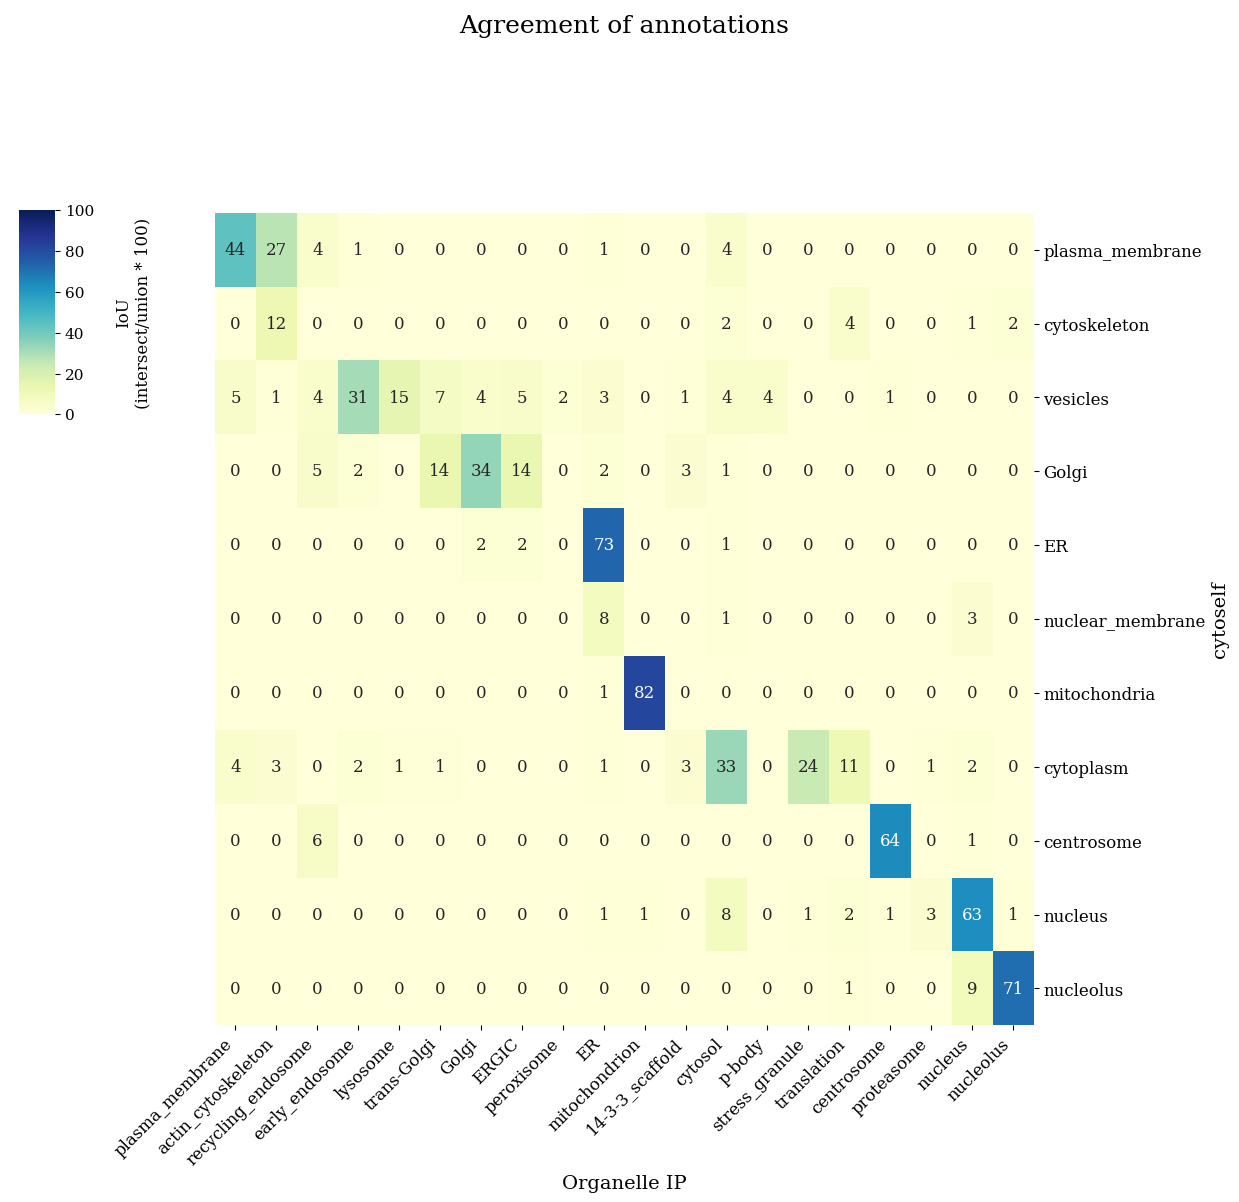

In [51]:
# Plot the confusion matrix as heatmap
import seaborn as sns
g = sns.clustermap(conflusion_df, 
                   annot=True, 
                   row_cluster=False, col_cluster=False,
                     cmap="YlGnBu",
                     vmax=100, vmin=0, 
                     annot_kws={"size": 12},
                     figsize=(12, 12,),
                     cbar_kws={"label": "IoU (intersect/union)"}
)

                     
# Rotate the x-axis tick labels by 45 degrees
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha="right")
# Adjust the title position
g.ax_heatmap.set_title("Agreement of annotations", pad=130, fontsize=18)  # Adjust the pad for the title
# Adjust the color bar position
g.cax.set_position([0.02, 0.65, 0.03, 0.17])  # [left, bottom, width, height]
# Add a title to the color bar
g.cax.set_ylabel("IoU\n(intersect/union * 100)", rotation=90, labelpad=15)
# Adjust the tick labels size
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12)  # X-axis labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)  # Y-axis labels
# Adjust the color bar label size
g.cax.yaxis.label.set_size(12)
# Adjust the color bar tick labels size
g.cax.tick_params(labelsize=11)
# Set x and y labels
g.ax_heatmap.set_xlabel('Organelle IP', fontsize=14)
g.ax_heatmap.set_ylabel('cytoself', fontsize=14)

plt.show()

### manually verify some of the values in the confusion matrix

In [52]:
# verify some of the values
list1_item = "cytoplasm"
list2_item = "14-3-3_scaffold"
list1 = data_single["annotations_grade3_simpler"].to_list()
list2 = data_single["graph_annotation"].to_list()


intersection = sum((l1 == list1_item and l2 == list2_item) for l1, l2 in zip(list1, list2))
union = sum((l1 == list1_item or l2 == list2_item) for l1, l2 in zip(list1, list2))
IoU = round(intersection / union *100) # in percentage

print(f"Cytoself: {list1_item}, OrgIP: {list2_item}")
print(f"Intersection: {intersection}, Union: {union}, IoU %: {IoU}")

Cytoself: cytoplasm, OrgIP: 14-3-3_scaffold
Intersection: 3, Union: 110, IoU %: 3


In [53]:
# verify some of the values
list1_item = "Golgi"
list2_item = "14-3-3_scaffold"
list1 = data_single["annotations_grade3_simpler"].to_list()
list2 = data_single["graph_annotation"].to_list()


intersection = sum((l1 == list1_item and l2 == list2_item) for l1, l2 in zip(list1, list2))
union = sum((l1 == list1_item or l2 == list2_item) for l1, l2 in zip(list1, list2))
IoU = round(intersection / union *100) # in percentage

print(f"Cytoself: {list1_item}, OrgIP: {list2_item}")
print(f"Intersection: {intersection}, Union: {union}, IoU %: {IoU}")

Cytoself: Golgi, OrgIP: 14-3-3_scaffold
Intersection: 1, Union: 33, IoU %: 3


In [54]:
# verify some of the values
list1_item = "Golgi"
list2_item = "recycling_endosome"
list1 = data_single["annotations_grade3_simpler"].to_list()
list2 = data_single["graph_annotation"].to_list()


intersection = sum((l1 == list1_item and l2 == list2_item) for l1, l2 in zip(list1, list2))
union = sum((l1 == list1_item or l2 == list2_item) for l1, l2 in zip(list1, list2))
IoU = round(intersection / union *100) # in percentage

print(f"Cytoself: {list1_item}, OrgIP: {list2_item}")
print(f"Intersection: {intersection}, Union: {union}, IoU %: {IoU}")

Cytoself: Golgi, OrgIP: recycling_endosome
Intersection: 2, Union: 37, IoU %: 5
